In [1]:
#!/usr/bin/env python
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
from utils import *
%reload_ext autoreload
%autoreload 2
from model import AtmosphereNetMLPtau
from dataset import KuruczDataset, load_dataset_file, create_dataloader_from_saved
from train import custom_loss
import smplotlib
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
def load_trained_model(model_path, hidden_size, depth_points, device):

    model = AtmosphereNetMLPtau(
            stellar_embed_dim=128, tau_embed_dim=64
            ).to(device)   
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model, checkpoint['epoch'], checkpoint['loss']


# Validate model
def validate_model(model, dataloader, device):
    model.eval()
    total_loss = 0
    param_losses = {'RHOX': 0.0, 'T': 0.0, 'P': 0.0, 
                   'XNE': 0.0, 'ABROSS': 0.0, 'ACCRAD': 0.0}
    
    all_inputs = []
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            all_inputs.append(inputs.cpu())
            outputs = model(inputs)
            loss, batch_param_losses = custom_loss(outputs, targets)
            
            total_loss += loss.item()
            for param, param_loss in batch_param_losses.items():
                param_losses[param] += param_loss.item()
            
            all_predictions.append(outputs.cpu())
            all_targets.append(targets.cpu())
    
    avg_loss = total_loss / len(dataloader)
    avg_param_losses = {k: v / len(dataloader) for k, v in param_losses.items()}
    
    all_inputs = torch.cat(all_inputs, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    
    return avg_loss, avg_param_losses, all_inputs, all_predictions, all_targets

In [3]:
train_loader, val_loader, dataset = create_dataloader_from_saved(
    # filepath="data/kurucz_vturb_0p5_tau_v3.pt",
    filepath="data/kurucz_v5.pt",
    batch_size=128,
    num_workers=0,
    device=torch.device("cpu"),
    validation_split=0.1
)

In [6]:
model_path = "checkpoints_0426_temp/final_model.pt"
model_hytro_path = "checkpoints_0426_hydro/final_model.pt"

hidden_size = 128
device = torch.device('cpu')

# Load dataset and model
model, epoch, train_loss = load_trained_model(
    model_path, hidden_size, dataset.max_depth_points, device
)

model_hydro, epoch_hydro, train_loss_hydro = load_trained_model(
    model_hytro_path, hidden_size, dataset.max_depth_points, device
)

# Validate model
val_loss, param_losses, inputs, predictions, targets = validate_model(model, val_loader, device)
val_loss_hydro, param_losses_hydro, inputs_hydro, predictions_hydro, targets_hydro = validate_model(model_hydro, val_loader, device)

# Plot a few sample profiles
torch.manual_seed(0)
# sample_indices = torch.randperm(predictions.shape[0])[:20]
# sample_indices = torch.arange(len(predictions))
num_samples = 2000
sample_indices = torch.randperm(num_samples)

In [7]:
# random seed
dP_dtau_ground_truth    = calculate_dP_dtau_ground_truth(dataset, sample_indices=sample_indices)
dP_dtau_predicted       = calculate_dP_dtau_predicted(model, dataset, sample_indices=sample_indices, device=device)
dP_dtau_predicted_hydro = calculate_dP_dtau_predicted(model_hydro, dataset, sample_indices=sample_indices, device=device)


In [9]:
n_samples = len(sample_indices)

loss_true, log_deriv_true, log_rhs_true = hydro_equilibrium_loss(targets[sample_indices,:,:], inputs[sample_indices,:], dataset, model)
loss, log_deriv, log_rhs = hydro_equilibrium_loss(predictions[sample_indices,:,:], inputs[sample_indices,:], dataset, model)
loss_hydro, log_deriv_hydro, log_rhs_hydro = hydro_equilibrium_loss(predictions_hydro[sample_indices,:,:], inputs[sample_indices,:], dataset, model_hydro)

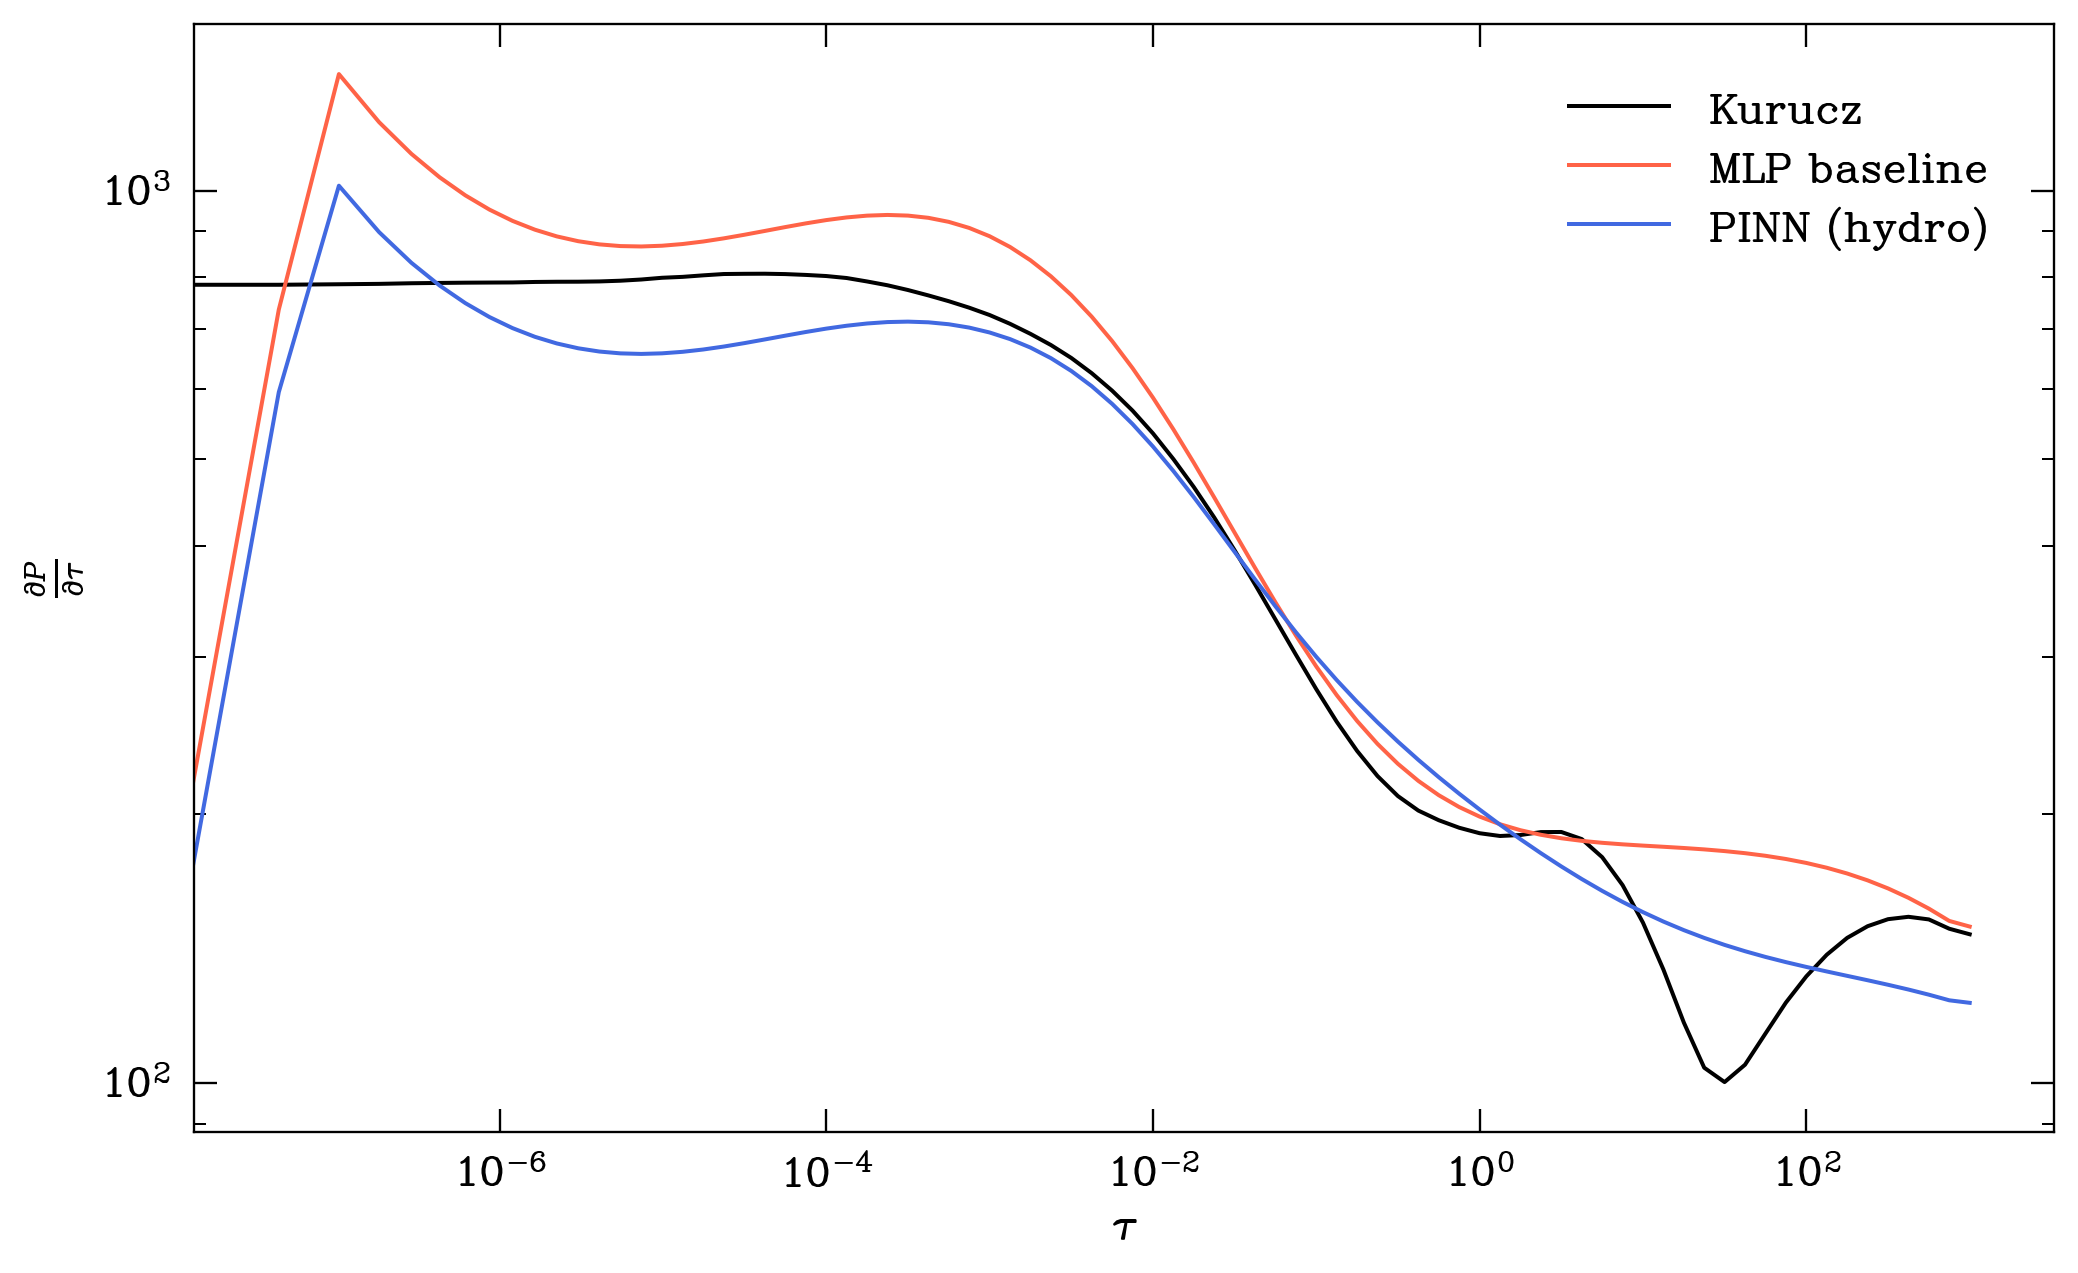

In [7]:
idx_plot = 0
# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(dP_dtau_ground_truth['tau'][idx_plot], 
        dP_dtau_ground_truth['dP_dtau'][idx_plot], 
        label='Kurucz', color='black')
ax.plot(dP_dtau_predicted['tau'][idx_plot], 
        dP_dtau_predicted['dP_dtau_pred'][idx_plot],
        label='MLP baseline', color='tomato')
ax.plot(dP_dtau_predicted_hydro['tau'][idx_plot], 
        dP_dtau_predicted_hydro['dP_dtau_pred'][idx_plot], 
        label='PINN (hydro)', color='royalblue')

ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$\frac{\partial P}{\partial \tau}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.show()


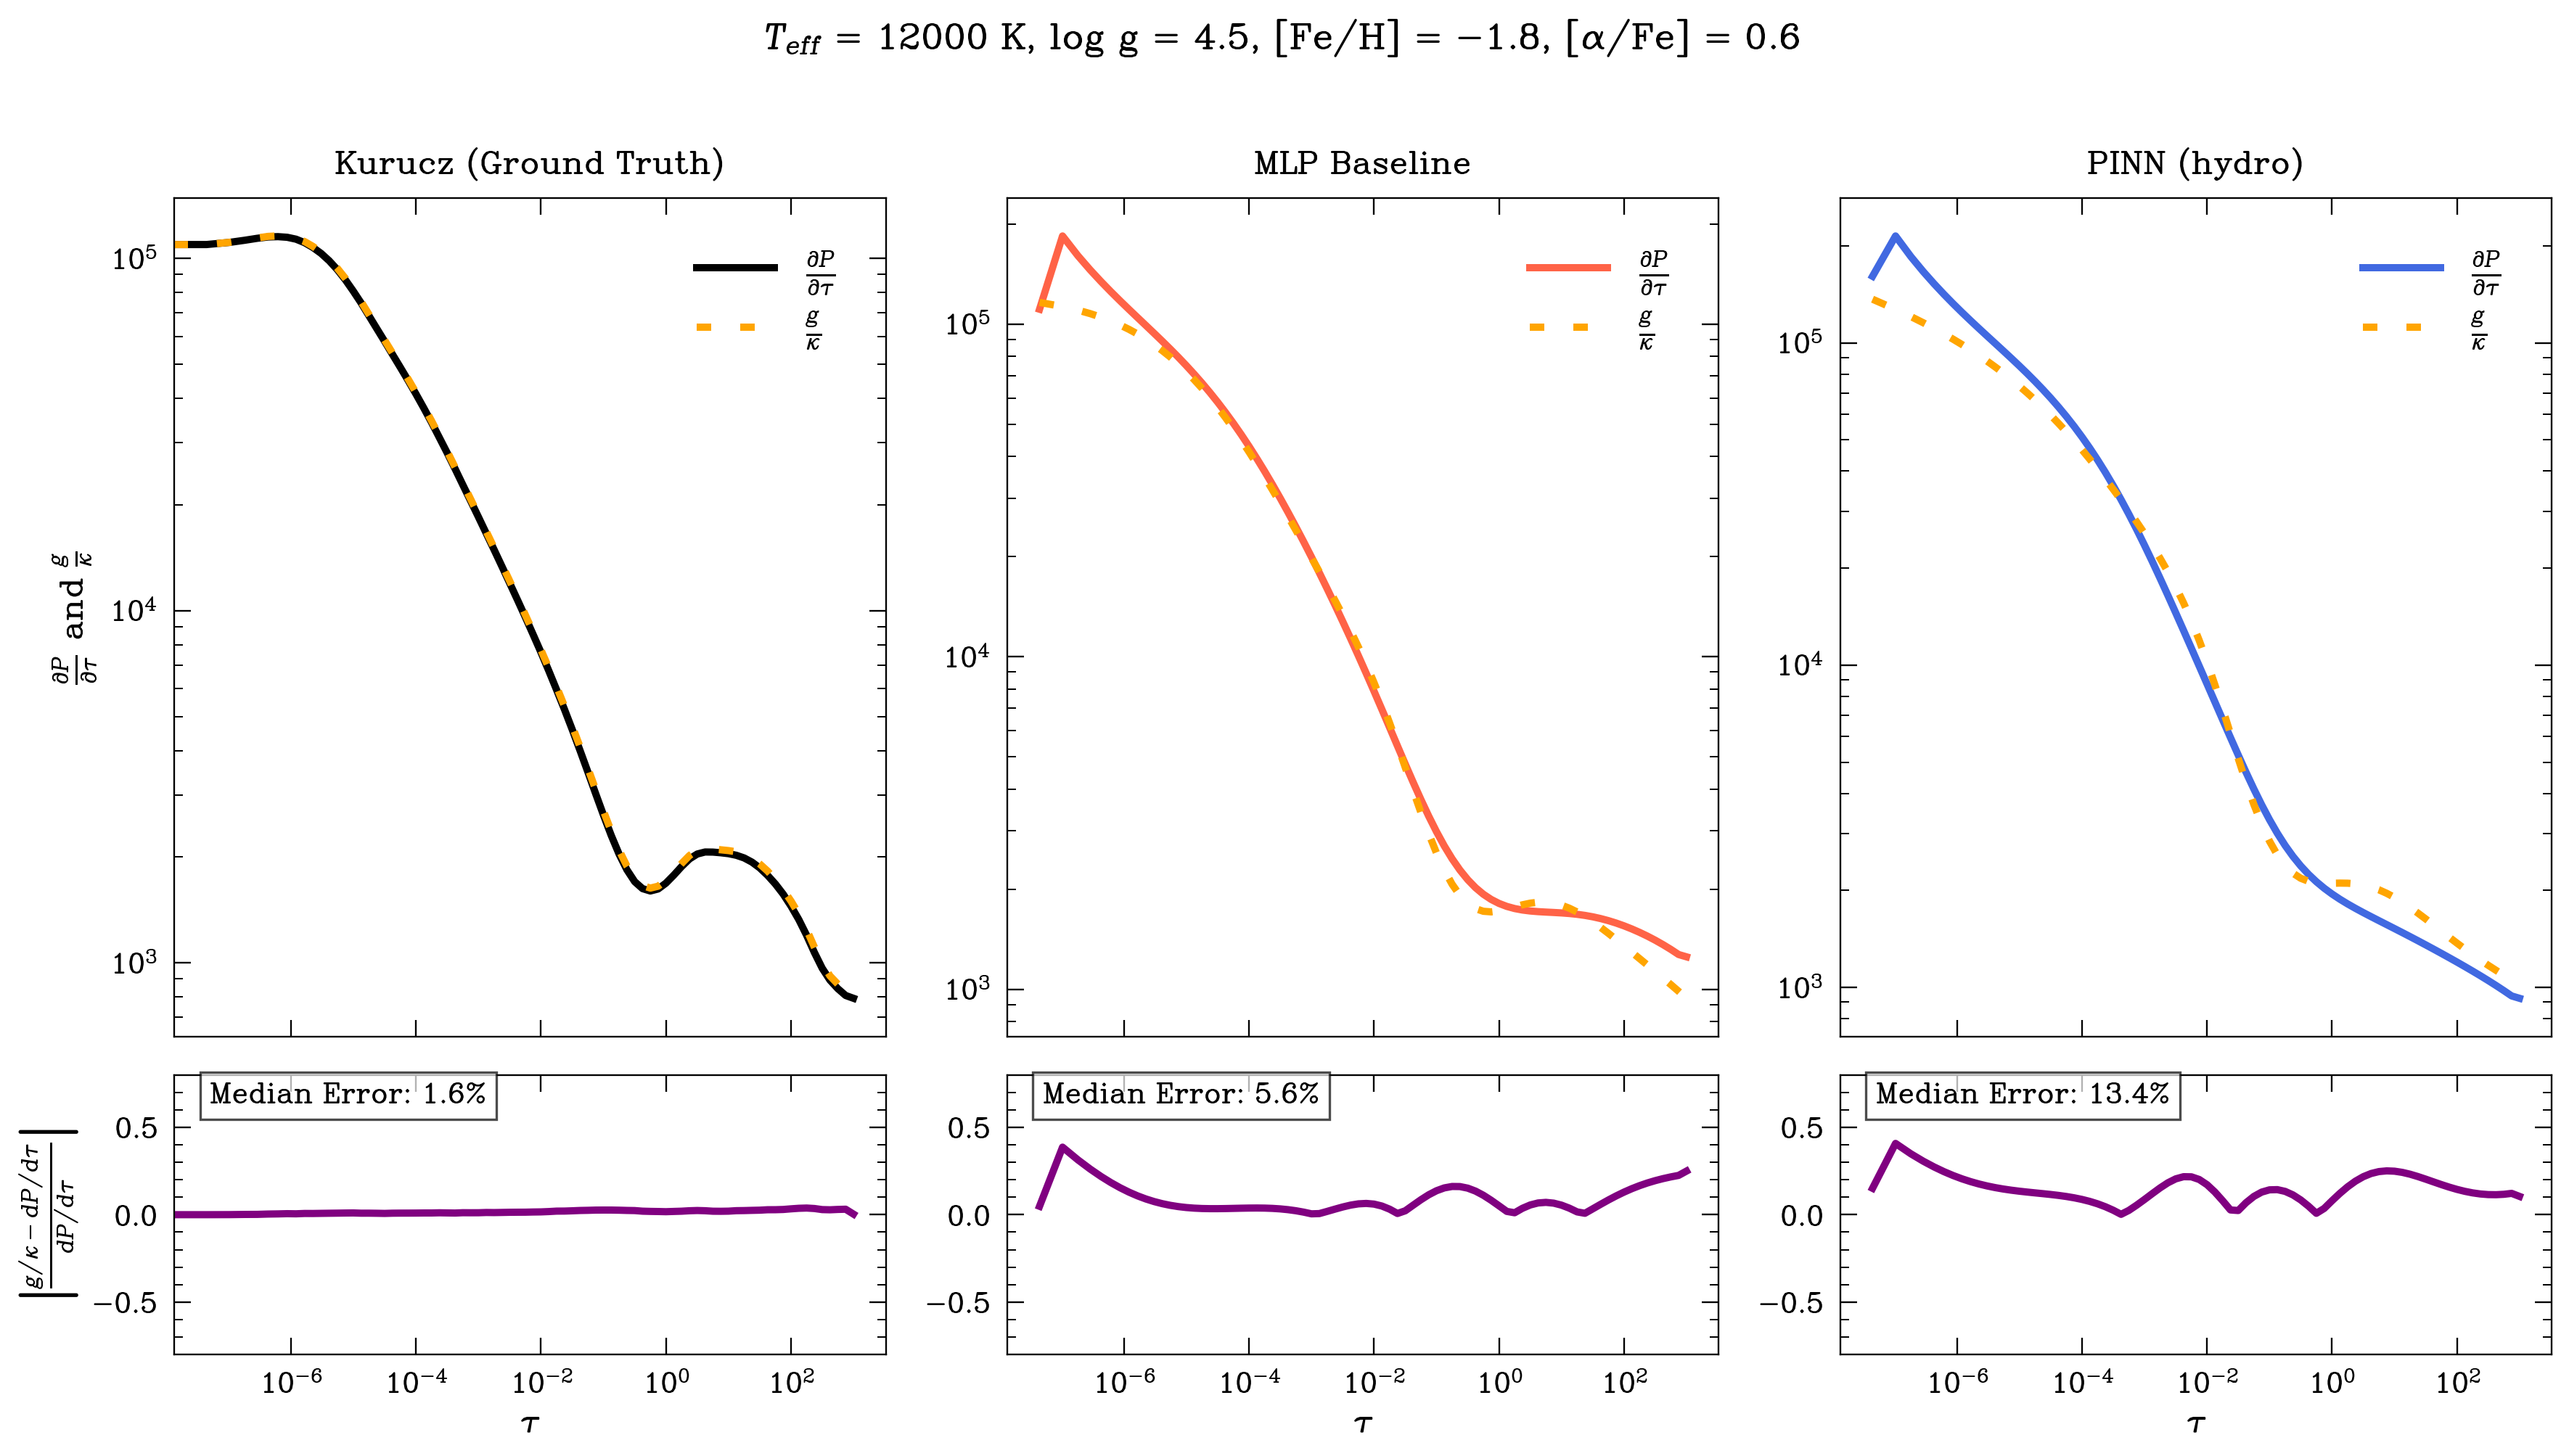

In [64]:
idx_plot = 77
# Get stellar parameters for the title
Teff = dP_dtau_ground_truth['teff'][idx_plot]
logg = np.log10(dP_dtau_ground_truth['gravity'][idx_plot])
FeH = dP_dtau_ground_truth['feh'][idx_plot]
alphaFe = dP_dtau_ground_truth['afe'][idx_plot]

# Set larger font size
plt.rcParams.update({'font.size': 14})

# Plotting with 2 rows (main plots and residuals)
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharex='col', 
                        gridspec_kw={'height_ratios': [3, 1]})

# Panel 1: Ground Truth (Kurucz)
axs[0, 0].plot(dP_dtau_ground_truth['tau'][idx_plot], 
              dP_dtau_ground_truth['dP_dtau'][idx_plot], 
              label=r'$\frac{\partial P}{\partial \tau}$', color='black', linewidth=3)
axs[0, 0].plot(dP_dtau_ground_truth['tau'][idx_plot], 
              dP_dtau_ground_truth['g_kappa'][idx_plot], 
              label=r'$\frac{g}{\kappa}$', color='orange', linestyle=':', linewidth=3)
axs[0, 0].set_title('Kurucz (Ground Truth)', fontsize=16)
axs[0, 0].set_ylabel(r'$\frac{\partial P}{\partial \tau}$ and $\frac{g}{\kappa}$', fontsize=16)
axs[0, 0].set_xscale('log')
axs[0, 0].set_yscale('log')
axs[0, 0].legend(fontsize=16)

start_point = 1

# Panel 2: MLP Baseline
axs[0, 1].plot(dP_dtau_predicted['tau'][idx_plot][start_point:], 
              dP_dtau_predicted['dP_dtau_pred'][idx_plot][start_point:],
              label=r'$\frac{\partial P}{\partial \tau}$', color='tomato', linewidth=3)
axs[0, 1].plot(dP_dtau_predicted['tau'][idx_plot][start_point:], 
              dP_dtau_predicted['g_kappa_pred'][idx_plot][start_point:], 
              label=r'$\frac{g}{\kappa}$', color='orange', linestyle=':', linewidth=3)
axs[0, 1].set_title('MLP Baseline', fontsize=16)
axs[0, 1].set_xscale('log')
axs[0, 1].set_yscale('log')
axs[0, 1].legend(fontsize=16)

# Panel 3: PINN (hydro)
axs[0, 2].plot(dP_dtau_predicted_hydro['tau'][idx_plot][start_point:], 
              dP_dtau_predicted_hydro['dP_dtau_pred'][idx_plot][start_point:], 
              label=r'$\frac{\partial P}{\partial \tau}$', color='royalblue', linewidth=3)
axs[0, 2].plot(dP_dtau_predicted_hydro['tau'][idx_plot][start_point:], 
              dP_dtau_predicted_hydro['g_kappa_pred'][idx_plot][start_point:], 
              label=r'$\frac{g}{\kappa}$', color='orange', linestyle=':', linewidth=3)
axs[0, 2].set_title('PINN (hydro)', fontsize=16)
axs[0, 2].set_xscale('log')
axs[0, 2].set_yscale('log')
axs[0, 2].legend(fontsize=16)


# Residual panels - showing relative errors
# Panel 1: Ground Truth relative errors
rel_error_gt = np.abs((dP_dtau_ground_truth['g_kappa'][idx_plot] - dP_dtau_ground_truth['dP_dtau'][idx_plot]) / dP_dtau_ground_truth['dP_dtau'][idx_plot])
median_error_gt = np.median(rel_error_gt) * 100  # Convert to percentage
axs[1, 0].plot(dP_dtau_ground_truth['tau'][idx_plot], rel_error_gt, 
              color='purple', linewidth=3)
axs[1, 0].set_xlabel(r'$\tau$', fontsize=16)
axs[1, 0].set_ylabel(r'$\left|\frac{g/\kappa - dP/d\tau}{dP/d\tau}\right|$', fontsize=16)
axs[1, 0].set_xscale('log')
axs[1, 0].set_ylim(-0.8, 0.8)
axs[1, 0].text(0.05, 0.9, f'Median Error: {median_error_gt:.1f}%', 
               transform=axs[1, 0].transAxes, fontsize=14, 
               bbox=dict(facecolor='white', alpha=0.7))

# Panel 2: MLP Baseline relative errors
rel_error_mlp = np.abs((dP_dtau_predicted['g_kappa_pred'][idx_plot][start_point:] - dP_dtau_predicted['dP_dtau_pred'][idx_plot][start_point:]) / dP_dtau_predicted['dP_dtau_pred'][idx_plot][start_point:])
median_error_mlp = np.median(rel_error_mlp) * 100  # Convert to percentage
axs[1, 1].plot(dP_dtau_predicted['tau'][idx_plot][start_point:], rel_error_mlp, 
              color='purple', linewidth=3)
axs[1, 1].set_xlabel(r'$\tau$', fontsize=16)
axs[1, 1].set_xscale('log')
axs[1, 1].text(0.05, 0.9, f'Median Error: {median_error_mlp:.1f}%', 
               transform=axs[1, 1].transAxes, fontsize=14,
               bbox=dict(facecolor='white', alpha=0.7))
axs[1, 1].set_ylim(-0.8, 0.8)

# Panel 3: PINN relative errors
rel_error_pinn = np.abs((dP_dtau_predicted_hydro['g_kappa_pred'][idx_plot][start_point:] - dP_dtau_predicted_hydro['dP_dtau_pred'][idx_plot][start_point:]) / dP_dtau_predicted_hydro['dP_dtau_pred'][idx_plot][start_point:])
median_error_pinn = np.median(rel_error_pinn) * 100  # Convert to percentage
axs[1, 2].plot(dP_dtau_predicted_hydro['tau'][idx_plot][start_point:], rel_error_pinn, 
              color='purple', linewidth=3)
axs[1, 2].set_xlabel(r'$\tau$', fontsize=16)
axs[1, 2].set_xscale('log')
axs[1, 2].text(0.05, 0.9, f'Median Error: {median_error_pinn:.1f}%', 
               transform=axs[1, 2].transAxes, fontsize=14,
               bbox=dict(facecolor='white', alpha=0.7))
axs[1, 2].set_ylim(-0.8, 0.8)
fig.suptitle(f'$T_{{eff}}$ = {Teff:.0f} K, log g = {logg:.1f}, [Fe/H] = {FeH:.1f}, [$\\alpha$/Fe] = {alphaFe:.1f}', 
             fontsize=18, y=1.05)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# MAD

In [10]:
mad_gt = torch.median(torch.abs(log_deriv_true - log_rhs_true), dim=1)[0].numpy()
mad_mlp = torch.median(torch.abs(log_deriv - log_rhs), dim=1)[0].numpy()
mad_hydro = torch.median(torch.abs(log_deriv_hydro - log_rhs_hydro), dim=1)[0].numpy()


print(mad_gt)
print(mad_mlp)
print(mad_hydro)

[0.10799861 0.10237908 0.11750937 ... 0.13361311 0.12606144 0.13120055]
[0.14902067 0.05788112 0.16369855 ... 0.20383644 0.19747734 0.19846773]
[0.02638674 0.09625101 0.04102039 ... 0.03216457 0.03635693 0.03705502]


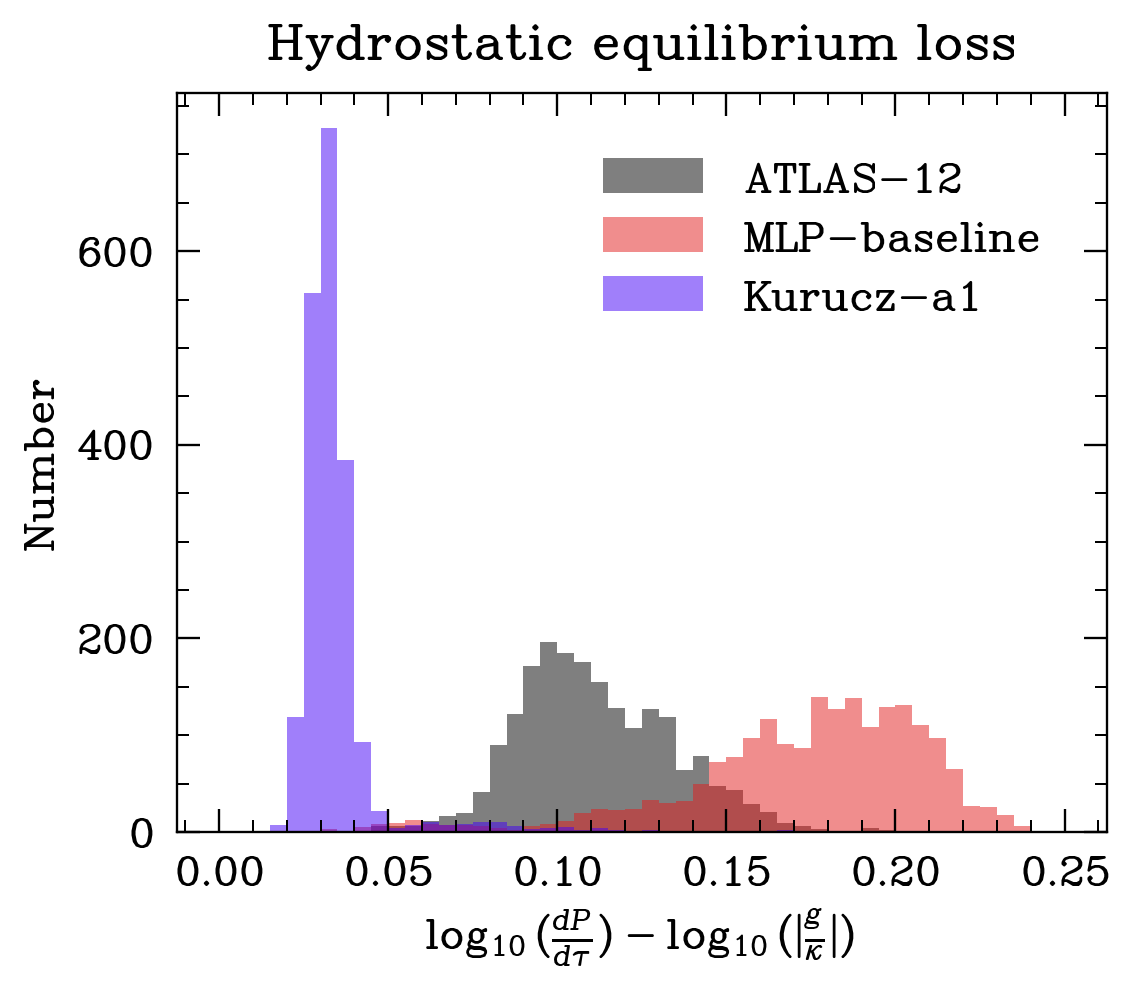

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

ax.hist(mad_gt, bins=50, alpha=0.5,    label='ATLAS-12', range=(0, 0.25))
ax.hist(mad_mlp, bins=50, alpha=0.5,   label='MLP-baseline', range=(0, 0.25))
ax.hist(mad_hydro, bins=50, alpha=0.5, label='Kurucz-a1', range=(0, 0.25))
ax.set_xlabel(r'$\log_{10}(\frac{dP}{d\tau}) - \log_{10}(|\frac{g}{\kappa}|)$ ')
ax.set_ylabel('Number')
ax.set_title(r'Hydrostatic equilibrium loss')
ax.legend()
plt.show()

fig.savefig('fig/hydro_loss.pdf')

In [12]:
teff_arr = np.array(dP_dtau_ground_truth['teff'])
logg_arr = np.log10(dP_dtau_ground_truth['gravity'])
feh_arr = np.array(dP_dtau_ground_truth['feh'])
afe_arr = np.array(dP_dtau_ground_truth['afe'])

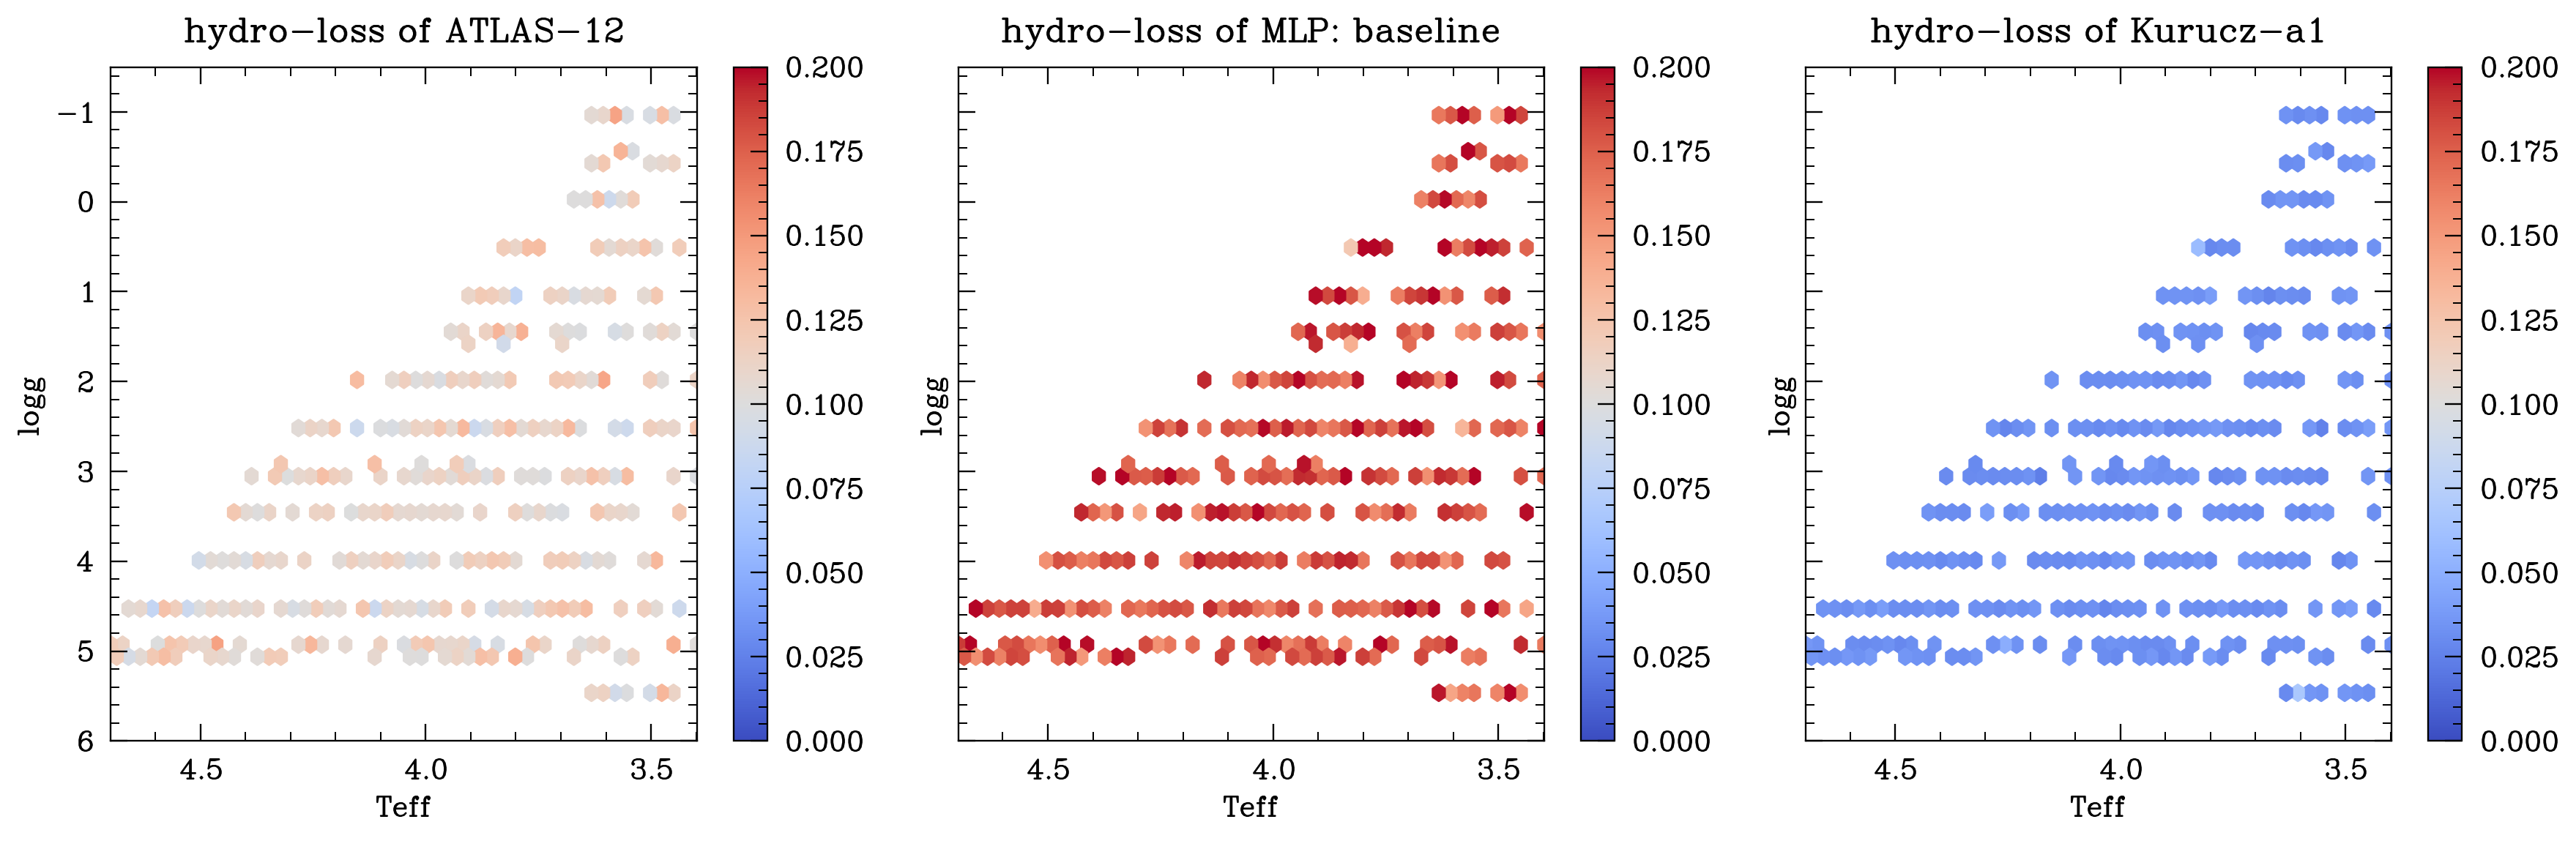

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Define variables, their titles, and their specific vmin/vmax values
variables = [
    (mad_gt, 'ATLAS-12', 0, 0.2),
    (mad_mlp, 'MLP: baseline', 0, 0.2),
    (mad_hydro, 'Kurucz-a1', 0, 0.2),
]

# Create all four plots
for i, (error, title, vmin, vmax) in enumerate(variables):
    hexplot = axs[i].hexbin(np.log10(teff_arr), logg_arr, C=error, 
                 gridsize=50, extent=[np.log10(2500), np.log10(50000), -1.5, 6], 
                 cmap='coolwarm', reduce_C_function=np.median,
                 mincnt=1, vmin=vmin, vmax=vmax)
    
    axs[i].set_xlabel('Teff')
    axs[i].set_ylabel('logg')
    axs[i].set_title(f'hydro-loss of {title}')
    axs[i].set_yscale('linear')
    axs[i].set_xlim(np.log10(50000), np.log10(2500))
    axs[i].set_ylim(6, -1.5)
    
    # Add a colorbar for each plot
    fig.colorbar(hexplot, ax=axs[i])

# Adjust the spacing between subplots
plt.tight_layout()

In [14]:
import pandas as pd
isochrones = pd.read_csv("~/Project/data/stellar_model/PARSEC_logage_6to10_MH_n2p5_0p6.csv")
isochrones.head()

def plot_isochrones(fig, ax, isochrones):
    """
    Plot stellar isochrones on a Kiel diagram with different colors for different ages.
    
    Parameters:
    -----------
    fig : matplotlib.figure.Figure
        The figure object to plot on
    ax : matplotlib.axes.Axes
        The axes object to plot on
    isochrones : pandas.DataFrame
        DataFrame containing isochrone data
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The updated figure object
    ax : matplotlib.axes.Axes
        The updated axes object
    """
    # Desired logAge (in years) and [M/H] values
    log_ages = [ 8.0, 9.0, 10.0]  # log10(age/yr)
    mh_values = [-1.0, 0.0]    # [M/H]

    # Colors for different stellar ages (instead of [M/H])
    # colors = ['C0', 'C1', 'C2', 'C3']  # One color per age
    colors = ['k', 'tab:orange', 'tab:green']

    # Filter and plot isochrones
    for i, log_age in enumerate(log_ages):
        color = colors[i]  # Assign color based on age
        
        for mh in mh_values:
            # Filter isochrone for specific logAge and [M/H]
            mask = (np.abs(isochrones['logAge'] - log_age) < 0.01) & (np.abs(isochrones['MH'] - mh) < 0.1) 
            mask_label = (isochrones['label']==0) | (isochrones['label']==1) | (isochrones['label']==2) | (isochrones['label']==3)
            
            iso_subset = isochrones[mask & mask_label]
            
            if len(iso_subset) == 0:
                print(f"No data for logAge={log_age}, [M/H]={mh}")
                continue
            
            # Calculate Teff from logTe
            teff = iso_subset['logTe']  # Convert logTe to Teff (K)
            logg = iso_subset['logg']
            
            # Plot isochrone with age-based color
            # Only add to legend for first metallicity value of each age
            if mh == mh_values[0]:
                label = f'logAge={log_age}'
            else:
                label = None
                
            ax.scatter(teff, logg, color=color, linewidths=0, label=label, s=1, alpha=0.5)

    # # Customize plot
    # ax.invert_xaxis()  # Invert Teff axis (hotter stars on the left)
    # ax.set_xlabel('Effective Temperature (Teff) [K]')
    # ax.set_ylabel('Surface Gravity (log g) [cgs]')
    # ax.set_title('Kiel Diagram with PARSEC Isochrones')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    # ax.grid(True)
    
    return fig, ax

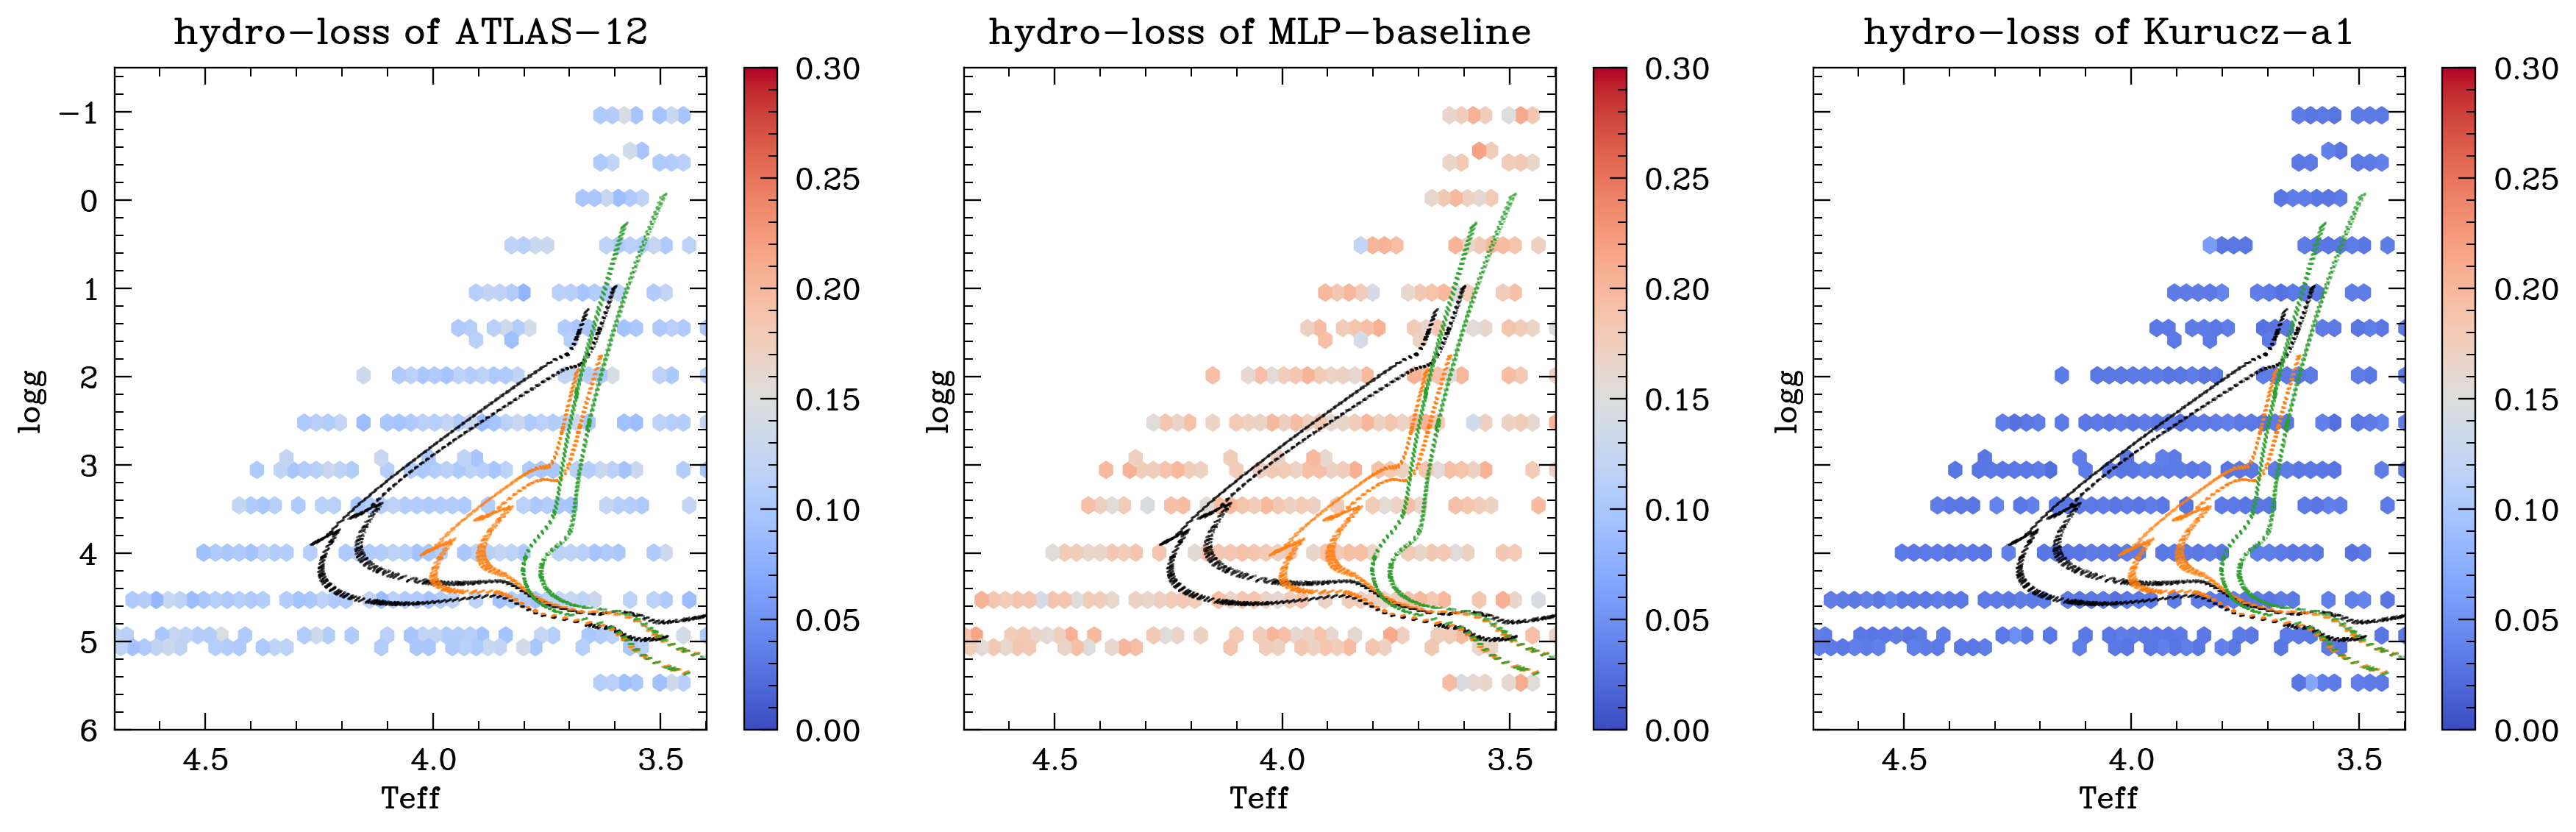

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Flatten the axes array for easier indexing
axs = axs.flatten()

color_list = ['k', 'tab:orange', 'tab:green']

# Define variables, their titles, and their specific vmin/vmax values
variables = [
    (mad_gt, 'ATLAS-12', 0, 0.3),
    (mad_mlp, 'MLP-baseline', 0, 0.3),
    (mad_hydro, 'Kurucz-a1', 0, 0.3),
]

# Create all four plots
for i, (error, title, vmin, vmax) in enumerate(variables):
    hexplot = axs[i].hexbin(np.log10(teff_arr), logg_arr, C=error, 
                 gridsize=50, extent=[np.log10(2500), np.log10(50000), -1.5, 6], 
                 cmap='coolwarm', reduce_C_function=np.median,
                 mincnt=1, vmin=vmin, vmax=vmax)
    
    axs[i].set_xlabel('Teff')
    axs[i].set_ylabel('logg')
    axs[i].set_title(f'hydro-loss of {title}')
    axs[i].set_yscale('linear')
    axs[i].set_xlim(np.log10(50000), np.log10(2500))
    axs[i].set_ylim(6, -1.5)
    
    fig, ax = plot_isochrones(fig, axs[i], isochrones)
    # Add a colorbar for each plot
    fig.colorbar(hexplot, ax=axs[i])

# Adjust the spacing between subplots
plt.tight_layout()

fig.savefig("fig/kiel_diagram_hydro_loss.png")

In [31]:
# Define solar parameters
solar_teff = 5000
solar_logg = 2.5
solar_feh = 0.0
solar_afe = 0.0
# Calculate distance in parameter space
# Normalize Teff by dividing by 1000 to make it comparable in scale to other parameters
param_distance = np.sqrt(2*((teff_arr - solar_teff)/1000)**2 + 
                         (logg_arr - solar_logg)**2 + 
                         2*(feh_arr - solar_feh)**2 + 
                         2*(afe_arr - solar_afe)**2)

# Find the index of the nearest model
nearest_idx = np.argmin(param_distance)

# Print the parameters of the nearest model
print(f"Nearest solar model index: {nearest_idx}")
print(f"Parameters of nearest model: Teff={teff_arr[nearest_idx]}, log g={logg_arr[nearest_idx]}, " +
      f"[Fe/H]={feh_arr[nearest_idx]}, [α/Fe]={afe_arr[nearest_idx]}")
print(f"Distance in parameter space: {param_distance[nearest_idx]}")

Nearest solar model index: 4187
Parameters of nearest model: Teff=5000.0009765625, log g=2.500000238418579, [Fe/H]=-0.25, [α/Fe]=0.20000000298023224
Distance in parameter space: 0.45276925954193264


In [29]:
def plot_hydrostatic_equilibrium(dP_dtau_ground_truth, dP_dtau_predicted, dP_dtau_predicted_hydro, idx_plot=375):
    """
    Plot hydrostatic equilibrium comparison between ground truth, MLP baseline, and PINN models.
    
    Parameters:
    -----------
    dP_dtau_ground_truth : dict
        Dictionary containing ground truth data
    dP_dtau_predicted : dict
        Dictionary containing MLP baseline predictions
    dP_dtau_predicted_hydro : dict
        Dictionary containing PINN (hydro) predictions
    idx_plot : int, optional
        Index of the model to plot (default: 375)
    """
    # Get stellar parameters for the title
    Teff = dP_dtau_ground_truth['teff'][idx_plot]
    logg = np.log10(dP_dtau_ground_truth['gravity'][idx_plot])
    FeH = dP_dtau_ground_truth['feh'][idx_plot]
    alphaFe = dP_dtau_ground_truth['afe'][idx_plot]

    # Set larger font size
    plt.rcParams.update({'font.size': 14})

    # Plotting with 2 rows (main plots and residuals)
    fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharex='col', 
                            gridspec_kw={'height_ratios': [3, 1]})

    # Panel 1: Ground Truth (Kurucz)
    axs[0, 0].plot(dP_dtau_ground_truth['tau'][idx_plot], 
                  dP_dtau_ground_truth['dP_dtau'][idx_plot], 
                  label=r'$\frac{\partial P}{\partial \tau}$', color='black', linewidth=3)
    axs[0, 0].plot(dP_dtau_ground_truth['tau'][idx_plot], 
                  dP_dtau_ground_truth['g_kappa'][idx_plot], 
                  label=r'$\frac{g}{\kappa}$', color='orange', linestyle=':', linewidth=3)
    axs[0, 0].set_title('Kurucz (Ground Truth)', fontsize=16)
    axs[0, 0].set_ylabel(r'$\frac{\partial P}{\partial \tau}$ and $\frac{g}{\kappa}$', fontsize=16)
    axs[0, 0].set_xscale('log')
    axs[0, 0].set_yscale('log')
    axs[0, 0].legend(fontsize=16)
    axs[0, 0].grid(True, alpha=0.3, which='both')

    start_point = 1

    # Panel 2: MLP Baseline
    axs[0, 1].plot(dP_dtau_predicted['tau'][idx_plot][start_point:], 
                  dP_dtau_predicted['dP_dtau_pred'][idx_plot][start_point:],
                  label=r'$\frac{\partial P}{\partial \tau}$', color='tomato', linewidth=3)
    axs[0, 1].plot(dP_dtau_predicted['tau'][idx_plot][start_point:], 
                  dP_dtau_predicted['g_kappa_pred'][idx_plot][start_point:], 
                  label=r'$\frac{g}{\kappa}$', color='orange', linestyle=':', linewidth=3)
    axs[0, 1].set_title('MLP Baseline', fontsize=16)
    axs[0, 1].set_xscale('log')
    axs[0, 1].set_yscale('log')
    axs[0, 1].legend(fontsize=16)
    axs[0, 1].grid(True, alpha=0.3, which='both')

    # Panel 3: PINN (hydro)
    axs[0, 2].plot(dP_dtau_predicted_hydro['tau'][idx_plot][start_point:], 
                  dP_dtau_predicted_hydro['dP_dtau_pred'][idx_plot][start_point:], 
                  label=r'$\frac{\partial P}{\partial \tau}$', color='royalblue', linewidth=3)
    axs[0, 2].plot(dP_dtau_predicted_hydro['tau'][idx_plot][start_point:], 
                  dP_dtau_predicted_hydro['g_kappa_pred'][idx_plot][start_point:], 
                  label=r'$\frac{g}{\kappa}$', color='orange', linestyle=':', linewidth=3)
    axs[0, 2].set_title('PINN (hydro)', fontsize=16)
    axs[0, 2].set_xscale('log')
    axs[0, 2].set_yscale('log')
    axs[0, 2].legend(fontsize=16)
    axs[0, 2].grid(True, alpha=0.3, which='both')

    # Residual panels - showing relative errors
    # Panel 1: Ground Truth relative errors
    rel_error_gt = np.abs((dP_dtau_ground_truth['g_kappa'][idx_plot] - dP_dtau_ground_truth['dP_dtau'][idx_plot]) / dP_dtau_ground_truth['dP_dtau'][idx_plot])
    median_error_gt = np.median(rel_error_gt) * 100  # Convert to percentage
    axs[1, 0].plot(dP_dtau_ground_truth['tau'][idx_plot], rel_error_gt, 
                  color='purple', linewidth=3)
    axs[1, 0].set_xlabel(r'$\tau$', fontsize=16)
    axs[1, 0].set_ylabel(r'$\left|\frac{g/\kappa - dP/d\tau}{dP/d\tau}\right|$', fontsize=16)
    axs[1, 0].set_xscale('log')
    axs[1, 0].set_ylim(-0.8, 0.8)
    axs[1, 0].grid(True, alpha=0.3, which='both')
    axs[1, 0].text(0.05, 0.9, f'Median Error: {median_error_gt:.1f}%', 
                   transform=axs[1, 0].transAxes, fontsize=14, 
                   bbox=dict(facecolor='white', alpha=0.7))

    # Panel 2: MLP Baseline relative errors
    rel_error_mlp = np.abs((dP_dtau_predicted['g_kappa_pred'][idx_plot][start_point:] - dP_dtau_predicted['dP_dtau_pred'][idx_plot][start_point:]) / dP_dtau_predicted['dP_dtau_pred'][idx_plot][start_point:])
    median_error_mlp = np.median(rel_error_mlp) * 100  # Convert to percentage
    axs[1, 1].plot(dP_dtau_predicted['tau'][idx_plot][start_point:], rel_error_mlp, 
                  color='purple', linewidth=3)
    axs[1, 1].set_xlabel(r'$\tau$', fontsize=16)
    axs[1, 1].set_xscale('log')
    axs[1, 1].grid(True, alpha=0.3, which='both')
    axs[1, 1].text(0.05, 0.9, f'Median Error: {median_error_mlp:.1f}%', 
                   transform=axs[1, 1].transAxes, fontsize=14,
                   bbox=dict(facecolor='white', alpha=0.7))
    axs[1, 1].set_ylim(-0.8, 0.8)

    # Panel 3: PINN relative errors
    rel_error_pinn = np.abs((dP_dtau_predicted_hydro['g_kappa_pred'][idx_plot][start_point:] - dP_dtau_predicted_hydro['dP_dtau_pred'][idx_plot][start_point:]) / dP_dtau_predicted_hydro['dP_dtau_pred'][idx_plot][start_point:])
    median_error_pinn = np.median(rel_error_pinn) * 100  # Convert to percentage
    axs[1, 2].plot(dP_dtau_predicted_hydro['tau'][idx_plot][start_point:], rel_error_pinn, 
                  color='purple', linewidth=3)
    axs[1, 2].set_xlabel(r'$\tau$', fontsize=16)
    axs[1, 2].set_xscale('log')
    axs[1, 2].grid(True, alpha=0.3, which='both')
    axs[1, 2].text(0.05, 0.9, f'Median Error: {median_error_pinn:.1f}%', 
                   transform=axs[1, 2].transAxes, fontsize=14,
                   bbox=dict(facecolor='white', alpha=0.7))
    axs[1, 2].set_ylim(-0.8, 0.8)
    
    fig.suptitle(f'$T_{{eff}}$ = {Teff:.0f} K, log g = {logg:.1f}, [Fe/H] = {FeH:.1f}, [$\\alpha$/Fe] = {alphaFe:.1f}', 
                 fontsize=18, y=1.05)

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    
    return fig, axs

# Example usage:
# fig, axs = plot_hydrostatic_equilibrium(dP_dtau_ground_truth, dP_dtau_predicted, dP_dtau_predicted_hydro, idx_plot=375)
# plt.show()